In [1]:
# we install MNE library that will be of use for data manipulation.
!pip install mne

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os
import ntpath


import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.8 MB/s eta 0:00:00


Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 47.4GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 1.75MB/s]

Download complete in 01m21s (46.1 MB)
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



<ipython-input-2-eccfb68a070a>:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(subject[0])
<ipython-input-2-eccfb68a070a>:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_train = mne.io.read_raw_edf(subject[0])
<ipython-input-2-eccfb68a070a>:14: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_train = mne.io.read_raw_edf(subject[0])
<ipython-input-2-eccfb68a070a>:19: RuntimeWarning: The unit for channel(s) EMG submental, Event marker, Resp oro-nasal, Temp rectal has changed from V to NA.
  raw_train.set_channel_types(mapping) #mapeo de canales
<ipython-input-2-eccfb68a070a>:22: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-

Using matplotlib as 2D backend.


<ipython-input-2-eccfb68a070a>:22: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  raw_train.plot(duration=30,scalings='auto', start=300 ) #start = 0, inicio de registro - W


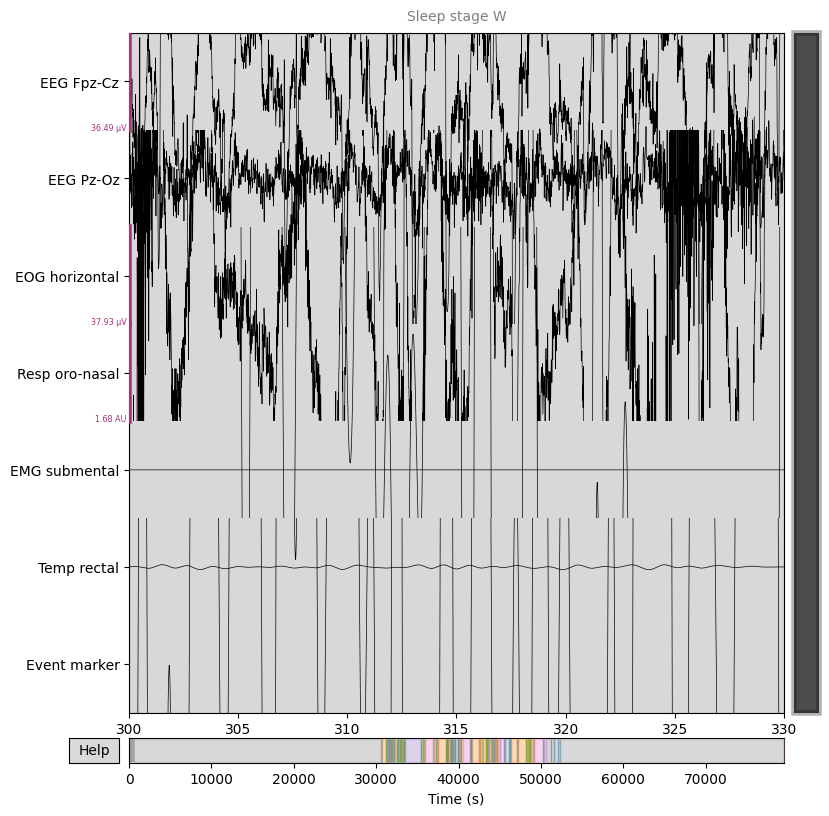

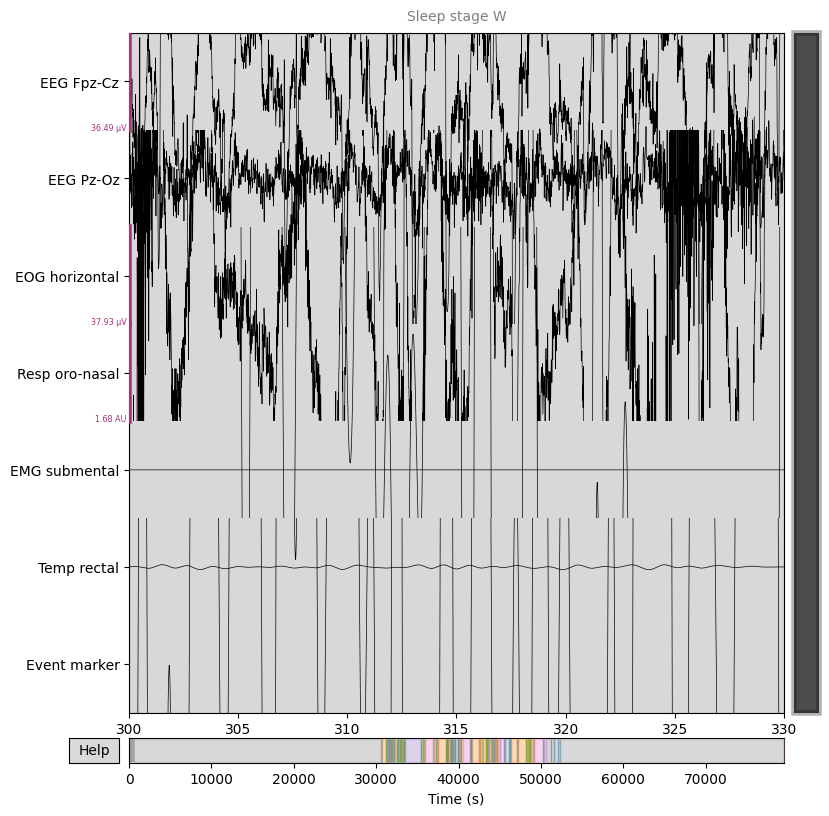

In [2]:
#fetching data for subject 0, recording 1
[subject] = fetch_data(subjects=[0], recording=[1] )


#Mapping of the channels
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}


# creating raw_train object with the *PSG.edf file of fetched data.
raw_train = mne.io.read_raw_edf(subject[0])

#The annot_train object has the annotations (labels) to be extracted from *Hypnogram.edf file of fetched data.
annot_train = mne.read_annotations(subject[1])
raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping) #mapeo de canales

# plot some data
raw_train.plot(duration=30,scalings='auto', start=300 ) #start = 0, inicio de registro - W


In [ ]:
#Each recording comes with metadata
print(raw_train.info)

#Sampling rate is an important variable
sampling_rate = raw_train.info['sfreq']

print('sampling_rate = {}'.format(sampling_rate))

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 2 EEG, 1 EOG, 4 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
sampling_rate = 100.0


In [ ]:
# UTILS

# This classes and methods have been extracted from Supratak et al. (2017) paper and code.
  # Please review https://github.com/akaraspt/deepsleepnet for further detail.

import re, datetime, operator
import numpy as np
from collections import namedtuple
from builtins import str

EVENT_CHANNEL = 'EDF Annotations'

class EDFEndOfData(BaseException): pass

def tal(tal_str):
  '''Return a list with (onset, duration, annotation) tuples for an EDF+ TAL
  stream.
  '''
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
    '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
    '(\x14(?P<annotation>[^\x00]*))?' + \
    '(?:\x14\x00)'

  def annotation_to_list(annotation):
    return annotation.split('\x14') if annotation else [] #str(annotation, 'latin_1')

  def parse(dic):
    return (
      float(dic['onset']),
      float(dic['duration']) if dic['duration'] else 0.,
      annotation_to_list(dic['annotation']))

  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]


def edf_header(f):
  h = {}
  assert f.tell() == 0  # check file position
  assert f.read(8) == '0       '

  # recording info)
  h['local_subject_id'] = f.read(80).strip()
  h['local_recording_id'] = f.read(80).strip()

  # parse timestamp
  (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
  (hour, minute, sec)= [int(x) for x in re.findall('(\d+)', f.read(8))]
  h['date_time'] = str(datetime.datetime(year + 2000, month, day,
    hour, minute, sec))

  # misc
  header_nbytes = int(f.read(8))
  subtype = f.read(44)[:5]
  h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
  h['contiguous'] = subtype != 'EDF+D'
  h['n_records'] = int(f.read(8))
  h['record_length'] = float(f.read(8))  # in seconds
  nchannels = h['n_channels'] = int(f.read(4))

  # read channel info
  channels = range(h['n_channels'])
  h['label'] = [f.read(16).strip() for n in channels]
  h['transducer_type'] = [f.read(80).strip() for n in channels]
  h['units'] = [f.read(8).strip() for n in channels]
  h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
  h['prefiltering'] = [f.read(80).strip() for n in channels]
  h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
  f.read(32 * nchannels)  # reserved

  assert f.tell() == header_nbytes
  return h


class BaseEDFReader:
  def __init__(self, file):
    self.file = file


  def read_header(self):
    self.header = h = edf_header(self.file)

    # calculate ranges for rescaling
    self.dig_min = h['digital_min']
    self.phys_min = h['physical_min']
    phys_range = h['physical_max'] - h['physical_min']
    dig_range = h['digital_max'] - h['digital_min']
    assert np.all(phys_range > 0)
    assert np.all(dig_range > 0)
    self.gain = phys_range / dig_range


  def read_raw_record(self):
    '''Read a record with data and return a list containing arrays with raw
    bytes.
    '''
    result = []
    for nsamp in self.header['n_samples_per_record']:
      samples = self.file.read(nsamp * 2)
      if len(samples) != nsamp * 2:
        raise EDFEndOfData
      result.append(samples)
    return result


  def convert_record(self, raw_record):
    '''Convert a raw record to a (time, signals, events) tuple based on
    information in the header.
    '''
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')
    signals = []
    events = []
    for (i, samples) in enumerate(raw_record):
      if h['label'][i] == EVENT_CHANNEL:
        ann = tal(samples)
        time = ann[0][0]
        events.extend(ann[1:])
        # print(i, samples)
        # exit()
      else:
        # 2-byte little-endian integers
        dig = np.fromstring(samples, '<i2').astype(np.float32)
        phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
        signals.append(phys)

    return time, signals, events


  def read_record(self):
    return self.convert_record(self.read_raw_record())


  def records(self):
    '''
    Record generator.
    '''
    try:
      while True:
        yield self.read_record()
    except EDFEndOfData:
      pass


def load_edf(edffile):
  '''Load an EDF+ file.
  Very basic reader for EDF and EDF+ files. While BaseEDFReader does support
  exotic features like non-homogeneous sample rates and loading only parts of
  the stream, load_edf expects a single fixed sample rate for all channels and
  tries to load the whole file.
  Parameters
  ----------
  edffile : file-like object or string
  Returns
  -------
  Named tuple with the fields:
    X : NumPy array with shape p by n.
      Raw recording of n samples in p dimensions.
    sample_rate : float
      The sample rate of the recording. Note that mixed sample-rates are not
      supported.
    sens_lab : list of length p with strings
      The labels of the sensors used to record X.
    time : NumPy array with length n
      The time offset in the recording for each sample.
    annotations : a list with tuples
      EDF+ annotations are stored in (start, duration, description) tuples.
      start : float
        Indicates the start of the event in seconds.
      duration : float
        Indicates the duration of the event in seconds.
      description : list with strings
        Contains (multiple?) descriptions of the annotation event.
  '''
  if isinstance(edffile, basestring):
    with open(edffile, 'rb') as f:
      return load_edf(f)  # convert filename to file

  reader = BaseEDFReader(edffile)
  reader.read_header()

  h = reader.header

  # get sample rate info
  nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
    if l != EVENT_CHANNEL])
  assert nsamp.size == 1, 'Multiple sample rates not supported!'
  sample_rate = float(nsamp[0]) / h['record_length']

  rectime, X, annotations = zip(*reader.records())
  X = np.hstack(X)
  annotations = reduce(operator.add, annotations)
  chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]

  # create timestamps
  if reader.header['contiguous']:
    time = np.arange(X.shape[1]) / sample_rate
  else:
    reclen = reader.header['record_length']
    within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
    time = np.hstack([t + within_rec_time for t in rectime])

  tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
  return tup(X, sample_rate, chan_lab, time, annotations)

In [ ]:
#if you are using Google Colab, before writing any files, you need to mount your Google Drive to the notebook with this cell

from google.colab import drive
drive.mount('/content/gdrive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# replace next variable (input_data_path) with your own path

input_data_path = '/content/gdrive/My Drive/Dataset3'


# we iterate over all recordings and subjects
for r in [1,2]:
  for i in [i for i in np.arange(20)]:

    if (i == 13) & (r ==2):
      continue


    [s1_files] = fetch_data(subjects=[i], recording=[r])
    select_ch = 'EEG Fpz-Cz'
    print('Files loaded: {} and {}'.format(s1_files[0], s1_files[1]))

    #We generate the object with signal data for each recording
    raw = read_raw_edf(s1_files[0], preload=True, stim_channel=None)
    sampling_rate = raw.info['sfreq']
    raw_ch_df = raw.to_data_frame(scalings=100.0)[select_ch] #default="EEG Fpz-Cz",
    raw_ch_df = raw_ch_df.to_frame()
    raw_ch_df.set_index(np.arange(len(raw_ch_df)))


    # we obtain the recording's metadata, or header.
    f = open(s1_files[0], 'r', encoding = 'latin_1')
    reader_raw = BaseEDFReader(f)
    reader_raw.read_header()
    h_raw = reader_raw.header
    f.close()
    raw_start_dt = dt.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

    f = open(s1_files[1], 'r')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header

    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = dt.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    assert raw_start_dt == ann_start_dt

    # Label values
    W = 0
    N1 = 1
    N2 = 2
    N3 = 3
    REM = 4
    UNKNOWN = 5

    stage_dict = { "W": W, "N1": N1, "N2": N2, "N3": N3, "REM": REM, "UNKNOWN": UNKNOWN }
    class_dict = { 0: "W", 1: "N1",  2: "N2", 3: "N3", 4: "REM", 5: "UNKNOWN" }
    ann2label = {  "Sleep stage W": 0, "Sleep stage 1": 1,"Sleep stage 2": 2, "Sleep stage 3": 3,
                "Sleep stage 4": 3,  "Sleep stage R": 4, "Sleep stage ?": 5, "Movement time": 5 }
    EPOCH_SEC_SIZE = 30


    # Vector with indices and labels
    remove_idx = []    # indicies of the data that will be removed
    labels = []        # indicies of the data that have labels
    label_idx = []
    for a in ann[0]:
      onset_sec, duration_sec, ann_char = a
      ann_str = "".join(ann_char)
      label = ann2label[ann_str]
      if label != UNKNOWN:
        if duration_sec % EPOCH_SEC_SIZE != 0:
          raise Exception("Something wrong")
        duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
        label_epoch = np.ones(duration_epoch, dtype=np.int) * label
        labels.append(label_epoch)
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        label_idx.append(idx)

      else:
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        remove_idx.append(idx)

    labels = np.hstack(labels)


    if len(remove_idx) > 0:
      remove_idx = np.hstack(remove_idx)
      select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
    else:
      select_idx = np.arange(len(raw_ch_df))

    # Only valid labels
    label_idx = np.hstack(label_idx)
    select_idx = np.intersect1d(select_idx, label_idx)


    # If necessary, extra indices are removed
    if len(label_idx) > len(select_idx):
        extra_idx = np.setdiff1d(label_idx, select_idx)
        # Vector tail is trimmed
        if np.all(extra_idx > select_idx[-1]):
            n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
            n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
            select_idx = select_idx[:-n_trims]
            labels = labels[:-n_label_trims]


    raw_ch = raw_ch_df.values[select_idx]

    # Vector should be splittable into 30 second periods
    if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
        raise Exception("Something wrong")
    n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

    x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
    y = labels.astype(np.int32)

    assert len(x) == len(y)

    # We keep only section that correspond to sleep.
    w_edge_mins = 30
    nw_idx = np.where(y != stage_dict["W"])[0]
    start_idx = nw_idx[0] - (w_edge_mins * 2) #60  epochs before sleep onset
    end_idx = nw_idx[-1] + (w_edge_mins * 2) # 60 epochs after sleep is finished
    if start_idx < 0: start_idx = 0
    if end_idx >= len(y): end_idx = len(y) - 1
    select2_idx = np.arange(start_idx, end_idx+1)
    raw_datapoint = x.shape[0]
    x = x[select2_idx]
    selected_datapoints = x.shape[0]
    y = y[select2_idx]
    cal =  (raw_datapoint - selected_datapoints )*100/raw_datapoint

    #print("Register went down from {} to {} or {} percent".format(raw_datapoint, selected_datapoints, np.round(cal,2)))


    filename = ntpath.basename(s1_files[0]).replace("-PSG.edf", ".npz")
    save_dict = {
        "x": x,
        "y": y,
        "fs": sampling_rate,
        "ch_label": select_ch,
        "header_raw": h_raw,
        "header_annotation": h_ann,
    }



    np.savez(os.path.join(input_data_path, filename), **save_dict)

    print('File {} was processed and saved'.format(s1_files[0]))

    print("\n=======================================\n")